In [ ]:

#! pip install xlrd

--2025-09-08 11:52:43--  https://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI.xls
Resolving biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)... 146.169.22.31
Connecting to biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)|146.169.22.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210432 (206K) [application/vnd.ms-excel]
Saving to: ‘IXI.xls’

IXI.xls             100%[===================>] 205.50K   937KB/s    in 0.2s    

2025-09-08 11:52:43 (937 KB/s) - ‘IXI.xls’ saved [210432/210432]



Index(['SEX_ID (1=m, 2=f)', 'HEIGHT', 'WEIGHT', 'ETHNIC_ID', 'MARITAL_ID',
       'OCCUPATION_ID', 'QUALIFICATION_ID', 'DOB', 'DATE_AVAILABLE',
       'STUDY_DATE', 'AGE'],
      dtype='object')


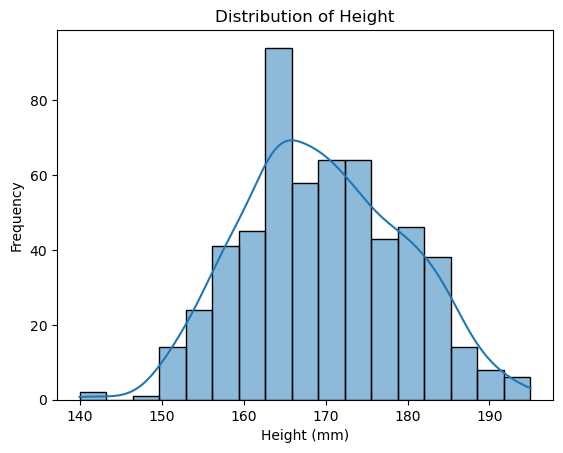

In [ ]:


df_behav = pd.read_csv('cleaned_IXI_behavioural.csv')
# index the df on IXI_ID
# get the ID in 3 digit format and prepend with 'sub-IXI'
df['IXI_ID'] = ['sub-IXI' + str(i).zfill(3) for i in df['IXI_ID'].values]
df.set_index('IXI_ID', inplace=True)
print(df.columns)



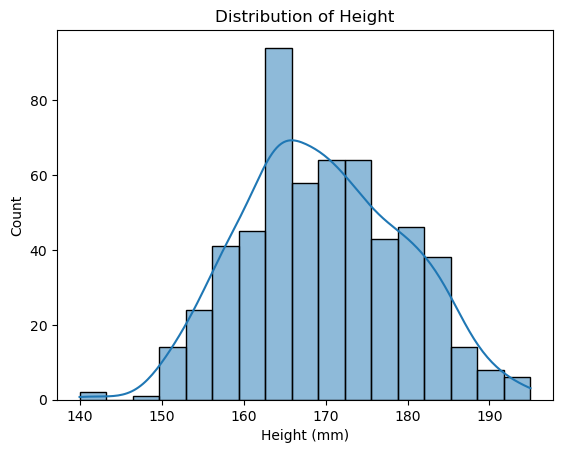

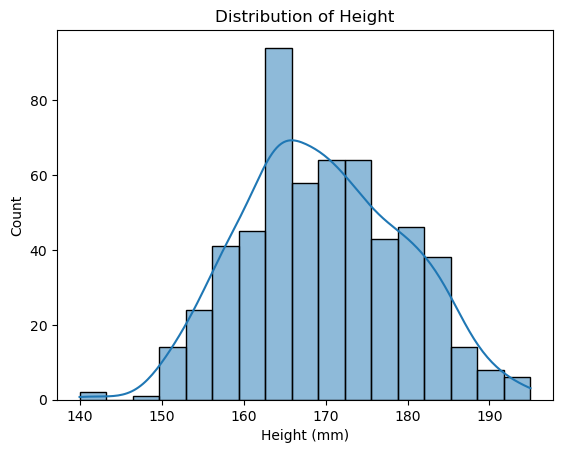

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_behav = pd.read_csv("cleaned_IXI_behavioural.csv")
df_behav.set_index("subjectID", inplace=True)

# histogram of height
sns.histplot(x="HEIGHT", data=df, kde=True)
plt.xlabel("Height (mm)")
plt.title("Distribution of Height")
plt.show()

# filter data for non-sensible HEIGHT values
height = df_behav["HEIGHT"].values
df_behav = df_behav[np.logical_and(height > 120, height < 200)]

# histogram of height
sns.histplot(x="HEIGHT", data=df_behav, kde=True)
plt.xlabel("Height (mm)")
plt.title("Distribution of Height")
plt.show()

In [14]:
# get the imaging data
df_GMV = pd.read_csv('cleaned_VBM_GM_Schaefer200x17_mean_aggregation.csv')
df_GMV.set_index('subjectID', inplace=True)
columns_GMV = df_GMV.columns.tolist()

In [18]:
# combine df and GMV
df_data = df_behav.join(df_GMV, how='inner')
print(df_data.head())

            SEX_ID (1=m, 2=f)  HEIGHT  WEIGHT         DOB  STUDY_DATE  \
subjectID                                                               
sub-IXI002                  2     164      58  1970-01-30  2005-11-18   
sub-IXI012                  1     175      70  1966-08-20  2005-06-01   
sub-IXI013                  1     182      70  1958-09-15  2005-06-01   
sub-IXI014                  2     163      65  1971-03-15  2005-06-09   
sub-IXI015                  1     181      90  1981-03-11  2005-06-23   

                  AGE  LH_VisCent_ExStr_1  LH_VisCent_ExStr_2  \
subjectID                                                       
sub-IXI002  35.800137            0.434407            0.431125   
sub-IXI012  38.781656            0.496368            0.487446   
sub-IXI013  46.710472            0.414027            0.445955   
sub-IXI014  34.236824            0.422764            0.369221   
sub-IXI015  24.284736            0.388491            0.398731   

            LH_VisCent_Striate_1

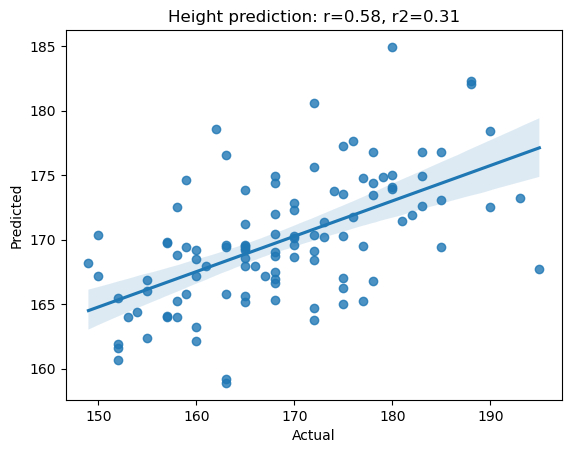

In [20]:
from sklearn.linear_model import Ridge
# do train-test split
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_data, test_size=0.2, random_state=1)

# train a model
model = Ridge()
model.fit(train_data[columns_GMV], train_data['HEIGHT'])

# predict
y_pred = model.predict(test_data[columns_GMV])
y_true = test_data['HEIGHT'].values

# get correlation and r2_Score
from sklearn.metrics import r2_score
r = np.corrcoef(y_true, y_pred)[0, 1]
r2 = r2_score(y_true, y_pred)

# scatterplot true versus predicted
# use seaborn 
sns.regplot(x=y_true, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Height prediction: r={r:.2f}, r2={r2:.2f}')
plt.show()


Fold 1: r = 0.577, r2 = 0.310
Fold 2: r = 0.571, r2 = 0.300
Fold 3: r = 0.564, r2 = 0.298
Fold 4: r = 0.556, r2 = 0.295
Fold 5: r = 0.612, r2 = 0.369
Training performance: Mean r = 0.728, Mean r2 = 0.511


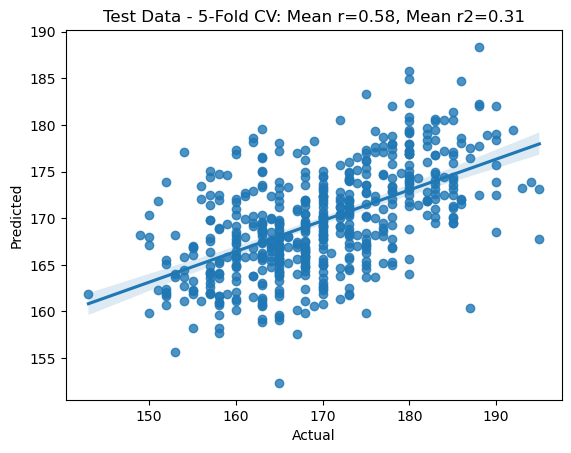

In [34]:
from sklearn.model_selection import KFold

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
all_true = []
all_pred = []
test_r_scores = []
test_r2_scores = []
train_r_scores = []
train_r2_scores = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

            # Train Ridge model
    model = Ridge()
    model.fit(train_data[columns_GMV], train_data['HEIGHT'])

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data['HEIGHT'].values

    # Store for global plot
    all_true.extend(y_true)
    all_pred.extend(y_pred)

    # Evaluate
    test_r = np.corrcoef(y_true, y_pred)[0, 1]
    test_r2 = r2_score(y_true, y_pred)
    test_r_scores.append(test_r)
    test_r2_scores.append(test_r2)

    print(f"Fold {fold+1}: r = {test_r:.3f}, r2 = {test_r2:.3f}")

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data['HEIGHT'].values
    train_r = np.corrcoef(y_train_true, y_train_pred)[0, 1]
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_r_scores.append(train_r)
    train_r2_scores.append(train_r2)

# Print training performance
print(f"Training performance: Mean r = {np.mean(train_r_scores):.3f}, Mean r2 = {np.mean(train_r2_scores):.3f}")

# Overall plot
sns.regplot(x=all_true, y=all_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test Data - 5-Fold CV: Mean r={np.mean(test_r_scores):.2f}, Mean r2={np.mean(test_r2_scores):.2f}')
plt.show()



Optimizing alpha values using nested CV
Fold 1: r = 0.577, r2 = 0.310, alpha = 1.0
Fold 2: r = 0.571, r2 = 0.300, alpha = 1.0
Fold 3: r = 0.564, r2 = 0.298, alpha = 1.0
Fold 4: r = 0.556, r2 = 0.295, alpha = 1.0
Fold 5: r = 0.598, r2 = 0.354, alpha = 0.5
Training performance: Mean r = 0.736, Mean r2 = 0.523


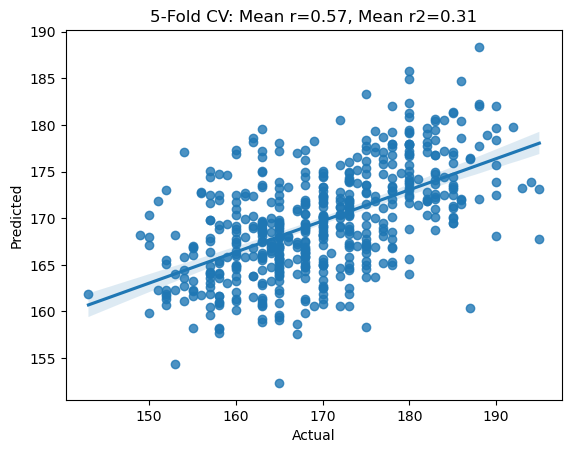

In [ ]:
# oh but we have one hyperparameter for Ridge
# alpha{float, ndarray of shape (n_targets,)}, default=1.0
#    Constant that multiplies the L2 term, controlling regularization strength. alpha must be a non-negative float i.e. in [0, inf).

from sklearn.model_selection import GridSearchCV

# define alpha values to tests
alphas = [0.01, 0.1, 0.5, 1.0, 10.0]
print('Optimizing alpha values using nested CV')

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
all_true = []
all_pred = []
test_r_scores = []
test_r2_scores = []
train_r_scores = []
train_r2_scores = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model while optimizing alpha in a for loop
    inner_score_max = -np.inf
    best_alpha = None
    for alpha in alphas:
        # Inner cross-validation: we need this to get the best alpha
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)
        inner_scores = []
        for train_index_inner, test_index_inner in inner_cv.split(train_data):
            train_data_inner = train_data.iloc[train_index_inner]
            test_data_inner = train_data.iloc[test_index_inner]
            model = Ridge(alpha=alpha)
            model.fit(train_data_inner[columns_GMV], train_data_inner['HEIGHT'])
            inner_scores.append(model.score(test_data_inner[columns_GMV], test_data_inner['HEIGHT']))
        mean_inner_score = np.mean(inner_scores)
        if mean_inner_score > inner_score_max:
            inner_score_max = mean_inner_score
            best_alpha = alpha

    # build model with best alpha
    best_alphas.append(best_alpha)
    model = Ridge(alpha=best_alpha)
    model.fit(train_data[columns_GMV], train_data['HEIGHT'])
    
    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data['HEIGHT'].values

    # Store for global plot
    all_true.extend(y_true)
    all_pred.extend(y_pred)

    # Evaluate
    test_r = np.corrcoef(y_true, y_pred)[0, 1]
    test_r2 = r2_score(y_true, y_pred)
    test_r_scores.append(test_r)
    test_r2_scores.append(test_r2)

    print(f"Fold {fold+1}: r = {test_r:.3f}, r2 = {test_r2:.3f}, alpha = {best_alpha}")

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data['HEIGHT'].values
    train_r = np.corrcoef(y_train_true, y_train_pred)[0, 1]
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_r_scores.append(train_r)
    train_r2_scores.append(train_r2)

print(f"Training performance: Mean r = {np.mean(train_r_scores):.3f}, Mean r2 = {np.mean(train_r2_scores):.3f}")

# Overall plot
sns.regplot(x=all_true, y=all_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'5-Fold CV: Mean r={np.mean(r_list):.2f}, Mean r2={np.mean(r2_list):.2f}')
plt.show()

Optimizing alpha values using grid search
Fold 1: r = 0.577, r2 = 0.310, alpha = 1.0
Fold 2: r = 0.571, r2 = 0.300, alpha = 1.0
Fold 3: r = 0.564, r2 = 0.298, alpha = 1.0
Fold 4: r = 0.556, r2 = 0.295, alpha = 1.0
Fold 5: r = 0.598, r2 = 0.354, alpha = 0.5


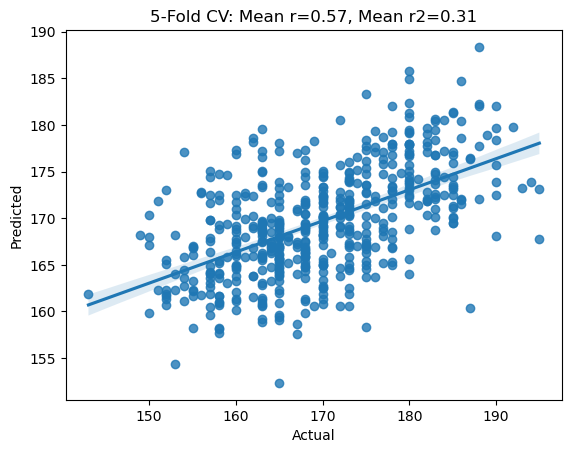

In [ ]:
# Now we do the same, but using scikit-learn's GridSearchCV

from sklearn.model_selection import GridSearchCV

# define the grid search for alpha values
param_grid = {"alpha": [0.01, 0.1, 0.5, 1.0, 10.0]}
print("Optimizing alpha values using grid search")

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
all_true = []
all_pred = []
r_list = []
r2_list = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Find best alpha using GridSearchCV instead of for loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)

    model = GridSearchCV(Ridge(), param_grid, cv=inner_cv, scoring="r2")  # r2 uses r2_score
    model.fit(train_data[columns_GMV], train_data["HEIGHT"])

    # when we predict using this model it will use the "best" alpha value, let's save that value
    best_alpha = model.best_params_["alpha"]
    best_alphas.append(best_alpha)

    # Predict using the best alpha
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["HEIGHT"].values

    # Store for global plot
    all_true.extend(y_true)
    all_pred.extend(y_pred)

    # Evaluate
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    r_list.append(r)
    r2_list.append(r2)

    print(f"Fold {fold+1}: r = {r:.3f}, r2 = {r2:.3f}, alpha = {best_alpha}")

# Overall plot
sns.regplot(x=all_true, y=all_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"5-Fold CV: Mean r={np.mean(r_list):.2f}, Mean r2={np.mean(r2_list):.2f}")
plt.show()

In [32]:
# let's move to classification

# first create a split for height
# using median height as cutoff
# according to NHS mean height for men is 175 and for women is 162
# let's take average of these two values as cutoff
height_cutoff = (175 + 162) / 2
print(f'Height cutoff: {height_cutoff} cm')

# create a new column in df for tall (1) and short (0)
df_data['TALL'] = (df_data['HEIGHT'] >= height_cutoff).astype(int)
df_data['TALL'].value_counts() # the classes look reasonably balanced

Height cutoff: 168.5 cm


TALL
1    273
0    266
Name: count, dtype: int64

In [ ]:
# do classification
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# define the grid search for alhpa values
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
print('Optimizing alpha values using grid search')

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
test_accuracies = []
test_roc_aucs = []
train_accuracies = []
train_roc_aucs = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model: now using GridSearchCV instead of for loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)

    model = GridSearchCV(RidgeClassifier(), param_grid, cv=inner_cv, scoring='accuracy') # accuracy for classification
    model.fit(train_data[columns_GMV], train_data['TALL'])
    # when we predict using this model it will use the "best" alpha value, let's save that value
    best_alpha = model.best_params_['alpha']
    best_alphas.append(best_alpha)

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data['TALL'].values

    # Evaluate
    test_acc = accuracy_score(y_true, y_pred)
    test_roc_auc = roc_auc_score(y_true, y_pred)
    test_accuracies.append(test_acc)
    test_roc_aucs.append(test_roc_auc)

    print(f"Fold {fold+1}: accuracy = {test_acc:.3f}, roc_auc = {test_roc_auc:.3f}, alpha = {best_alpha}")

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data['TALL'].values
    train_acc = accuracy_score(y_train_true, y_train_pred)
    train_roc_auc = roc_auc_score(y_train_true, y_train_pred)
    train_accuracies.append(train_acc)
    train_roc_aucs.append(train_roc_auc)


# print mean accuracy
print(f'Mean accuracy (train): {np.mean(train_accuracies):.3f}, Mean ROC AUC (train): {np.mean(train_roc_aucs):.3f}')
print(f'Mean accuracy (test): {np.mean(test_accuracies):.3f}, Mean ROC AUC (test): {np.mean(test_roc_aucs):.3f}')

Optimizing alpha values using grid search
Fold 1: accuracy = 0.704, roc_auc = 0.706, alpha = 1.0
Fold 2: accuracy = 0.648, roc_auc = 0.648, alpha = 0.5
Fold 3: accuracy = 0.713, roc_auc = 0.715, alpha = 1.0
Fold 4: accuracy = 0.731, roc_auc = 0.731, alpha = 1.0
Fold 5: accuracy = 0.710, roc_auc = 0.710, alpha = 10.0
Mean accuracy (train): 0.809, Mean ROC AUC (train): 0.809
Mean accuracy (test): 0.701, Mean ROC AUC (test): 0.702


In [47]:
# do classification
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline
pipeline = Pipeline([("scaler", StandardScaler()), ("ridge", RidgeClassifier())])


# define the grid search for alpha values
param_grid = {"ridge__alpha": [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0, 100, 1000, 10000]}
print("Optimizing alpha values using grid search")

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
test_accuracies = []
test_roc_aucs = []
train_accuracies = []
train_roc_aucs = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model: now using GridSearchCV instead of for loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)

    # Use a pipeline to scale the data before classification

    model = GridSearchCV(
        pipeline, param_grid, cv=inner_cv, scoring="accuracy"
    )  # accuracy for classification
    model.fit(train_data[columns_GMV], train_data["TALL"])
    # when we predict using this model it will use the "best" alpha value, let's save that value
    best_alpha = model.best_params_["ridge__alpha"]
    best_alphas.append(best_alpha)

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["TALL"].values

    # Evaluate
    test_acc = accuracy_score(y_true, y_pred)
    test_roc_auc = roc_auc_score(y_true, y_pred)
    test_accuracies.append(test_acc)
    test_roc_aucs.append(test_roc_auc)

    print(
        f"Fold {fold+1}: accuracy = {test_acc:.3f}, roc_auc = {test_roc_auc:.3f}, alpha = {best_alpha}"
    )

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data["TALL"].values
    train_acc = accuracy_score(y_train_true, y_train_pred)
    train_roc_auc = roc_auc_score(y_train_true, y_train_pred)
    train_accuracies.append(train_acc)
    train_roc_aucs.append(train_roc_auc)


# print mean accuracy
print(
    f"Mean accuracy (train): {np.mean(train_accuracies):.3f}, Mean ROC AUC (train): {np.mean(train_roc_aucs):.3f}"
)
print(
    f"Mean accuracy (test): {np.mean(test_accuracies):.3f}, Mean ROC AUC (test): {np.mean(test_roc_aucs):.3f}"
)

Optimizing alpha values using grid search
Fold 1: accuracy = 0.722, roc_auc = 0.726, alpha = 100
Fold 2: accuracy = 0.704, roc_auc = 0.704, alpha = 1000
Fold 3: accuracy = 0.694, roc_auc = 0.698, alpha = 1000
Fold 4: accuracy = 0.713, roc_auc = 0.713, alpha = 1000
Fold 5: accuracy = 0.738, roc_auc = 0.739, alpha = 1000
Mean accuracy (train): 0.778, Mean ROC AUC (train): 0.778
Mean accuracy (test): 0.714, Mean ROC AUC (test): 0.716
